# 🎯 Fashion Demand Forecasting – Code Notebook

This notebook implements the core components of the project *"A Machine Learning Approach to Forecasting Demand in the Fashion Industry"*. The goal is to predict dominant color trends for future fashion seasons using machine learning techniques, and to optimize product planning accordingly.

## 📚 Notebook Structure

1. **Data Preparation** – Load and format historical color forecast data.
2. **Clustering (K-Means)** – Identify color trend clusters from previous seasons.
3. **Bayesian Network** – Estimate seasonal color probabilities based on past trends.
4. **KNN Forecasting** – Generate a color forecast vector using weighted averages.
5. **Linear Programming (LP)** – Optimize color distribution to maximize expected profit.



In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsRegressor
import ast

In [93]:
# Pick K_clusters
K_clusters = 6
# Pick  K-neighbors
KN = 3

For using exsiting data:

In [ ]:
color_forecast_data = pd.read_csv(r'') # insert path to data

In [95]:
color_forecast_data.head()

,year,season,color_forecast
0,1970,1,[0.35348956 0.42691548 0.21959496]
1,1970,2,[0.23764988 0.07259318 0.68975694]
2,1970,3,[0.46744434 0.4452506 0.08730506]
3,1970,4,[0.7821397 0.08165934 0.13620096]
4,1970,5,[0.41956731 0.36904543 0.21138726]


In [96]:
def convert_color_forecast_column(df: pd.DataFrame, column_name: str = 'color_forecast') -> pd.DataFrame:
    """
    Convert a DataFrame column containing string representations of numeric arrays
    into actual NumPy arrays.

    This function parses strings formatted like "[0.1 0.2 0.3]" and converts them
    into NumPy arrays of floats. The original DataFrame is not modified; a copy is returned.

    Parameters:
    ----------
    df : pd.DataFrame
        The input DataFrame containing the column to convert.

    column_name : str, optional (default='color_forecast')
        The name of the column to be converted.

    Returns:
    -------
    pd.DataFrame
        A copy of the input DataFrame with the specified column converted to arrays of floats.
    """
    df = df.copy()
    df[column_name] = df[column_name].apply(lambda s: np.fromstring(s.strip('[]'), sep=' '))
    return df

In [97]:
# Convert the 'color_forecast' column to actual NumPy arrays
color_forecast_data = convert_color_forecast_column(color_forecast_data, 'color_forecast')

#### Scatter Plot

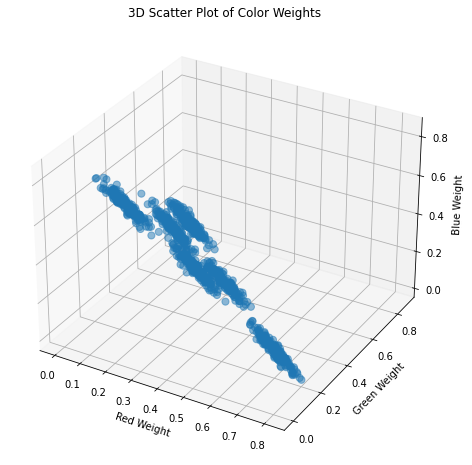

In [98]:
# Prepare the data for 3D plotting
red_weights = []
green_weights = []
blue_weights = []

for _, row in color_forecast_data.iterrows():
    red_weights.append(row['color_forecast'][0])
    green_weights.append(row['color_forecast'][1])
    blue_weights.append(row['color_forecast'][2])

# Create the 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(red_weights, green_weights, blue_weights,  s=50, alpha=0.5)
ax.set_xlabel('Red Weight')
ax.set_ylabel('Green Weight')
ax.set_zlabel('Blue Weight')
ax.set_title('3D Scatter Plot of Color Weights')

plt.show()

#### Step 1.1 Kmeans

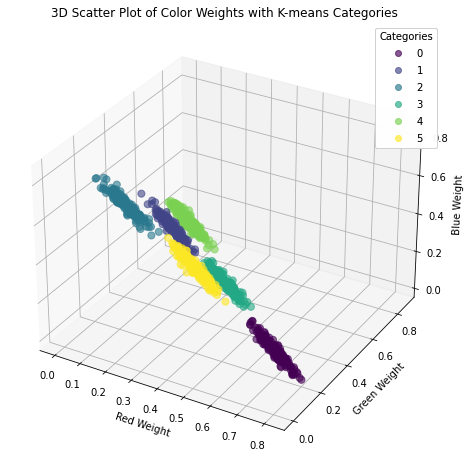

In [99]:
# Prepare the data for 3D plotting and clustering
color_weights = np.array(color_forecast_data['color_forecast'].tolist())

# Apply K-means clustering
kmeans = KMeans(n_clusters=K_clusters, random_state=42)
color_forecast_data['category'] = kmeans.fit_predict(color_weights)

# Write the categorized data to a new CSV file
#color_forecast_data.to_csv('categorized_color_forecast_data.csv', index=False)

#print("Categorized data has been written to 'categorized_color_forecast_data.csv'")

# Create the 3D scatter plot with categories
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

categories = color_forecast_data['category']
scatter = ax.scatter(color_weights[:, 0], color_weights[:, 1], color_weights[:, 2], c=categories, cmap='viridis', s=50, alpha=0.6)

ax.set_xlabel('Red Weight')
ax.set_ylabel('Green Weight')
ax.set_zlabel('Blue Weight')
ax.set_title('3D Scatter Plot of Color Weights with K-means Categories')

# Add a legend
legend1 = ax.legend(*scatter.legend_elements(), title="Categories")
ax.add_artist(legend1)

plt.show()

In [100]:
color_forecast_data.head()

,year,season,color_forecast,category
0,1970,1,"[0.35348956, 0.42691548, 0.21959496]",3
1,1970,2,"[0.23764988, 0.07259318, 0.68975694]",2
2,1970,3,"[0.46744434, 0.4452506, 0.08730506]",3
3,1970,4,"[0.7821397, 0.08165934, 0.13620096]",0
4,1970,5,"[0.41956731, 0.36904543, 0.21138726]",3


#### Step 2 determining the catagory of the next season

In [101]:
# Prepare the dataset for Naive Bayes
X = color_forecast_data[['year', 'season']]
y = color_forecast_data['category']

# Train the Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X, y)

# Function to predict the probabilities for all categories for a given (year, season)
def predict_category_probabilities(year, season):
    probabilities = nb_model.predict_proba([[year, season]])
    return probabilities[0]

# Example prediction
year, season = 2023, 1
predicted_probabilities = predict_category_probabilities(year, season)
print(f'The predicted probabilities for (year={year}, season={season}) are: {predicted_probabilities}')



The predicted probabilities for (year=2023, season=1) are: [0.21940932 0.13250996 0.21073931 0.09850957 0.15540144 0.18343039]


#### Step 3

Training KNN

In [102]:
# Function to train KNN models for each category
def train_knn_models(data, KN):
    knn_models = {}
    for category in np.unique(data['category']):
        # Filter data for the current category
        category_data = data[data['category'] == category]
        # Prepare features and target
        X = category_data[['year', 'season']]
        y = np.array(category_data['color_forecast'].tolist())
        # Train KNN model for the current category
        knn = KNeighborsRegressor(n_neighbors=KN)
        knn.fit(X, y)
        knn_models[category] = knn
    return knn_models


# Train KNN models
knn_models = train_knn_models(color_forecast_data,KN)


In [103]:
# Function to predict colors for a given (year, season) using KNN and Naive Bayes
def predict_colors(year, season,num_catagories):
    # Get the category probabilities
    category_probabilities = predict_category_probabilities(year, season)

    # Initialize lists to hold the weighted color predictions
    weighted_red = 0
    weighted_green = 0
    weighted_blue = 0

    # Make predictions for each category using the KNN models
    for category in range(num_catagories):
        if category in knn_models:
            knn = knn_models[category]
            # Predict color weights for the current category
            color_weights_pred = knn.predict([[year, season]])[0]
            # Weighted sum of the predictions
            weighted_red += color_weights_pred[0] * category_probabilities[category]
            weighted_green += color_weights_pred[1] * category_probabilities[category]
            weighted_blue += color_weights_pred[2] * category_probabilities[category]

    return (weighted_red, weighted_green, weighted_blue)

In [104]:
# Example prediction

year, season = 2023, 1
predicted_colors = predict_colors(year, season,K_clusters)
# Display category probabilities
for i, prob in enumerate(predicted_probabilities):
    print(f'Category {i}: {prob:.4f}')


# Display the predicted color weights for the new prediction
print(f'The predicted color weights for (year={year}, season={season}) are: Red: {predicted_colors[0]:.4f}, Green: {predicted_colors[1]:.4f}, Blue: {predicted_colors[2]:.4f}')

Category 0: 0.2194
Category 1: 0.1325
Category 2: 0.2107
Category 3: 0.0985
Category 4: 0.1554
Category 5: 0.1834
The predicted color weights for (year=2023, season=1) are: Red: 0.3484, Green: 0.3161, Blue: 0.3355


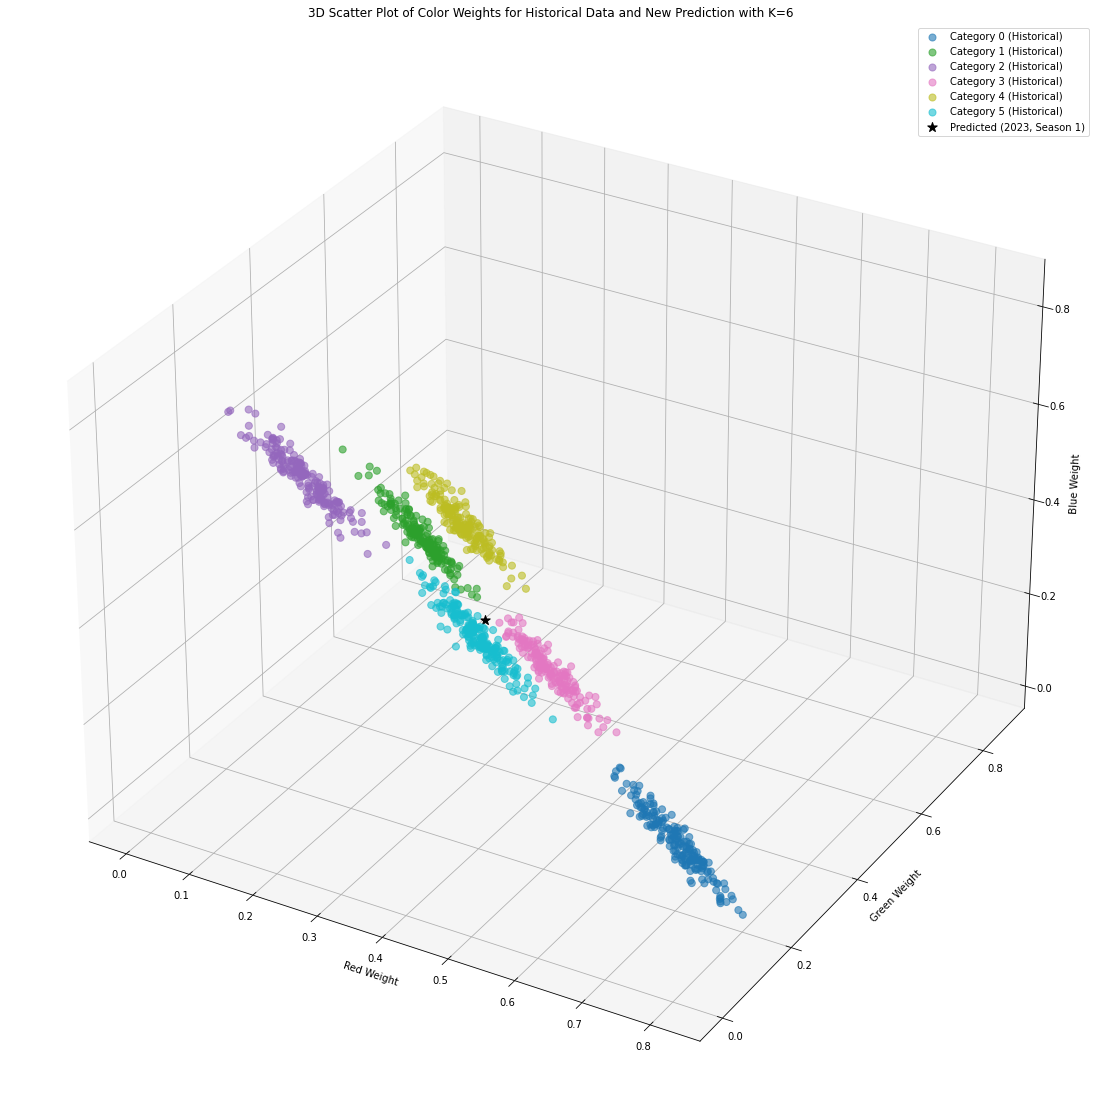

In [105]:
# Get category for the new prediction
new_category = nb_model.predict([[year, season]])[0]

# Plotting the data with new prediction
fig = plt.figure(figsize=(30, 20))
ax = fig.add_subplot(111, projection='3d')

# Define a color map for the categories
colors = plt.cm.get_cmap('tab10', K_clusters)  # Use a colormap with enough distinct colors

# Scatter plot for all data points
for category in range(K_clusters):
    category_data = color_forecast_data[color_forecast_data['category'] == category]
    color_weights = np.array(category_data['color_forecast'].tolist())
    ax.scatter(color_weights[:, 0], color_weights[:, 1], color_weights[:, 2],
               color=colors(category), label=f'Category {category} (Historical)', alpha=0.6, s=50)

# Scatter plot for the new prediction
ax.scatter(predicted_colors[0], predicted_colors[1], predicted_colors[2],
           color='black', label='Predicted (2023, Season 1)', s=100, marker='*', edgecolor='k')

ax.set_xlabel('Red Weight')
ax.set_ylabel('Green Weight')
ax.set_zlabel('Blue Weight')
ax.set_title(f'3D Scatter Plot of Color Weights for Historical Data and New Prediction with K={K_clusters}')
ax.legend()

plt.show()